In [3]:
# load appropriate modules
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
from matplotlib import colors, ticker, cm
import xrft
#import gsw

In [5]:
# Make dictionary
res_time = {"20":{'dt':1200, 'iter1': 5702400, 'iterend':5728320},
            "05":{'dt':300, 'iter1':10368000, 'iterend':10471680}, 
            "01":{'dt':40 , 'iter1':1166400, 'iterend':2073600}}

for keys in res_time.keys():
    res_time[keys]['dirname']='/swot/SUM05/dbalwada/channel_beta/{0}km/tracer_exp1/'.format(keys)

In [6]:
res_time['20']['dt_out'] = 18
res_time['05']['dt_out'] = 72
res_time['01']['dt_out'] = 21600

In [7]:
# Load data
for keys in res_time.keys():
    
    npick = 40 # pick up every npick'th file as the original out is very dense (12 hours)
    
    dt_out = int(res_time[keys]['dt_out'])
    T1 = int(res_time[keys]['iter1'])
    T2 = int(res_time[keys]['iterend'])
    #T6months = int(0.5*(T1+T2))
    T340days = int(T1 + (T2-T1)*34/36)
    
    if keys == '01':
        npick=1
        T340days = T2 
    
    iters = range(T1, T340days, dt_out*npick)
    
    ds = open_mdsdataset(res_time[keys]['dirname'],  iters=iters, 
                             delta_t=res_time[keys]['dt'], prefix=['U','V','T','W','PTRACER01']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_main']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [39]:
res_time['20']

{'data_main': <xarray.Dataset>
 Dimensions:              (XC: 100, XG: 100, YC: 100, YG: 100, Z: 76, Zl: 76, Zp1: 77, Zu: 76, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 34)
 Coordinates:
   * XG                   (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 ...
   * YC                   (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 ...
   * YG                   (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 ...
   * XC                   (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 ...
   * Z                    (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
   * Zu                   (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
   * Zl                   (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 ...
   * Zp1                  (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 ...
     dyG                  (YC, XG) >f4 dask.array<shape=(100, 100), chunksize=(100, 100)>
     rA                   (YC, XC) >f4 dask.array<shape=(100, 10

In [23]:
ds = res_time['20']['data_main']

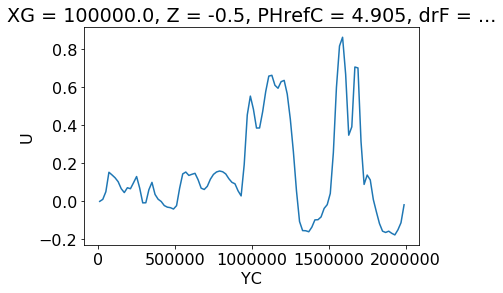

In [31]:
ds.U.sel(XG=100e3, method='nearest').isel(time=0,Z=0).plot()

In [33]:
mgrid = Grid(ds, periodic='X')

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z (76) --> left
  * left     Zl (76) --> center
  * outer    Zp1 (77) --> center
  * right    Zu (76) --> center
Y Axis (not periodic):
  * center   YC (100) --> left
  * left     YG (100) --> center
X Axis (periodic):
  * center   XC (100) --> left
  * left     XG (100) --> center
T Axis (not periodic):
  * center   time (34)
1TH Axis (not periodic):
  * center   layer_1TH_center (42) --> outer
  * outer    layer_1TH_bounds (43) --> center
  * inner    layer_1TH_interface (41) --> center

In [37]:
Ux = mgrid.interp(mgrid.diff(ds.U, 'X'),'X')

In [38]:
Ux

<xarray.DataArray 'mul-895660e10812b9393181a4515c8c98f2' (time: 34, Z: 76, YC: 100, XG: 100)>
dask.array<shape=(34, 76, 100, 100), dtype=float32, chunksize=(1, 76, 100, 1)>
Coordinates:
  * time     (time) int64 6842880000 6843744000 6844608000 6845472000 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...

In [5]:
# Load data for only a single day of the simulation.
for keys in res_time.keys():
    
    npick = 40 # pick up every npick'th file as the original out is very dense (12 hours)
    
    dt_out = int(res_time[keys]['dt_out'])
    T1 = int(res_time[keys]['iter1'])
    T2 = int(res_time[keys]['iterend'])
    
    T340days = int(T1 + (T2-T1)*34/36)
    T170days = int(0.5*(T1+T340days))
    
    if keys == '01':
        npick=1
        T340days = T2 
        T170days = int(0.5*(T1+T2))
    
    iters = range(T1, T340days, dt_out*npick)
    
    ds = open_mdsdataset(res_time[keys]['dirname'],  iters=T170days, 
                             delta_t=res_time[keys]['dt'], prefix=['PTRACER01','U','V']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_main']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [13]:
Hmix_perc = {'01': 148.91334609985336, '05': 200.39475387573242, '20': 272.41587585449213}

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


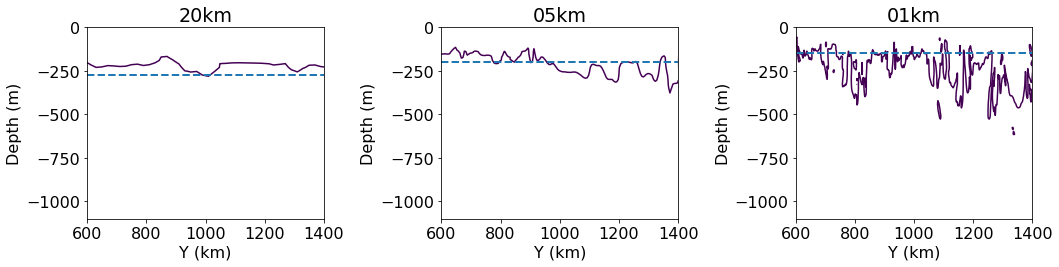

In [40]:
plt.figure(figsize=(15,4))
plt.rcParams['font.size']=16
n=0
for key in ['20','05','01']: 
    plt.subplot(131 + n)
    ds = res_time[key]['data_main']['PTRACER01'].isel(XC=0, time=3)
    plt.contour(ds.YC/1e3, ds.Z, ds, levels =[0.1], linewidth=2)
    x = np.linspace(600,1400,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '--', linewidth=2)
    n+=1
    plt.xlim([600,1400])
    plt.ylim([-1100,0])
    plt.xlabel('Y (km)')
    plt.ylabel('Depth (m)')
    plt.title(key + 'km')
plt.tight_layout()

In [6]:
# Load data
for keys in res_time.keys():
    
    npick = 1 # pick up every npick'th file as the original out is very dense (12 hours)
    
    dt_out = int(res_time[keys]['dt_out'])
    T1 = int(res_time[keys]['iter1'])
    T2 = int(res_time[keys]['iterend'])
    T340days = int(T1 + (T2-T1)*34/36)
    #T6months = int(0.5*(T1+T2))
    
    if keys == '01':
        npick=1
        T340days = T2 
    
    iters = range(T1+dt_out, T340days, dt_out*npick)
    
    ds = open_mdsdataset(res_time[keys]['dirname'], iters = T340days, 
                             delta_t=res_time[keys]['dt'], prefix=['KPP_surf', 'KPP_parameters']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_others']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


# interlude in notebook to calculate the vertical profile of diffusivity

In [20]:
start = 0.0
stop = 1.0
number_of_lines=9
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ plt.cm.Set1(x) for x in cm_subsection ]

In [21]:
label = {"20":"20 km", "01":"1 km", "05":"5 km"}

In [18]:
Hmix_perc = {'01': 144.28248626708978, '05': 198.28811721801759, '20': 271.59768463134759}

KeyError: 'data_others'

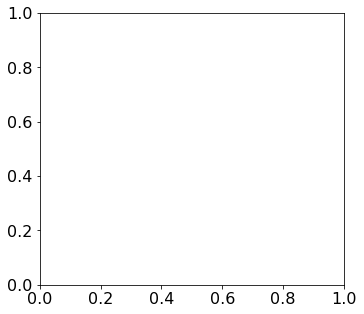

In [41]:
plt.figure(figsize=(12, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=2
for key in ['01','05','20']:
    x = np.linspace(-1,1,20)
    plt.subplot(121)
    diff = res_time[key]['data_others'].KPPdiffS.isel(time=-1).sel(XC=slice(1000e3,1800e3), 
                                                                   YC=slice(600e3,1400e3)).mean(['XC','YC'])
    plt.plot(diff, diff.Zl, '-', label=label[key],linewidth=2, color=colors[n])
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    plt.subplot(122)
    diff = res_time[key]['data_others'].KPPdiffS.isel(time=-1).sel(XC=slice(0,800e3), 
                                                                   YC=slice(600e3,1400e3)).mean(['XC','YC'])
    plt.plot(diff, diff.Zl, '-', label=label[key], linewidth=2, color=colors[n])
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1
    
plt.legend()

plt.subplot(121)
plt.ylim([-400,0])
plt.xlim([0,0.16])
plt.xlabel('Diffusivity ($m^2/s$)')
plt.ylabel('Depth (m)')

plt.subplot(122)
plt.ylim([-400,0])
plt.xlim([0,0.16])
plt.xlabel('Diffusivity ($m^2/s$)')
plt.ylabel('Depth (m)')

plt.tight_layout()

plt.savefig('figures/diffusivity_regions_KPP.eps', format='eps', dpi=300)

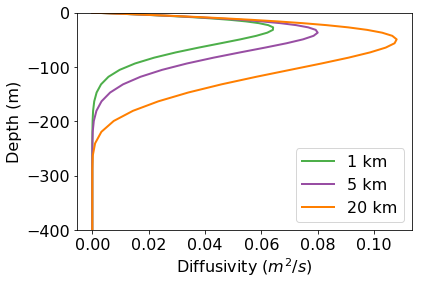

In [11]:
plt.rcParams['font.size'] = 16

n=2
for key in ['01','05','20']:
    
    diff = res_time[key]['data_others'].KPPdiffS.isel(
        time=-1).sel(YC=slice(600e3,1400e3)).mean(['XC','YC'])
    plt.plot(diff, diff.Zl, '-', label=label[key],linewidth=2, color=colors[n])
    

    n+=1
    
plt.legend()
plt.ylim([-400,0])
plt.xlabel('Diffusivity ($m^2/s$)')
plt.ylabel('Depth (m)')

plt.savefig('figures/diffusivity_KPP.eps', format='eps', dpi=300)

# back to old code

In [9]:
def time_average(ds, n): 
    l = len(ds.time)/n
    
    temp = []
    temp_time = []
    for j in range(0, int(l)):
        
        temp.append(ds.isel(time=slice(j*n, (j+1)*n-1)).mean('time'))
        
        temp_time.append(ds.time.isel(time=(j+1)*n-1))

    ds_coarse = xr.concat(temp, temp_time)
    ds_coarse = ds_coarse.rename({'concat_dim':'time'})
    
    return ds_coarse

In [10]:
KPP_coarse = {}
KPP_coarse['01'] = res_time['01']['data_others']

for keys in ['20','05']:
    KPP_coarse[keys] = time_average(res_time[keys]['data_others'],40 )

In [11]:
# get all the time axis to be the same for coarsened KPP variables
for keys in res_time.keys():

    time_updated =  KPP_coarse[keys].time -  KPP_coarse[keys].time[0] 
    KPP_coarse[keys].__setitem__('time', time_updated.values)
    
    #time_updated2 = res_time[keys]['data_main'].time - res_time[keys]['data_main'].time[0] 
    #res_time[keys]['data_main'].__setitem__('time', time_updated2.values)
    

In [12]:
# get all the time axis to be the same for main variables
for keys in res_time.keys():

    time_updated2 = res_time[keys]['data_main'].time - res_time[keys]['data_main'].time[0] 
    res_time[keys]['data_main'].__setitem__('time', time_updated2.values)

In [ ]:
for keys in res_time.keys():
    KPP_coarse[keys].load()
#    res_time[keys]['data_others'].load()

In [13]:
ylevs = [600e3,1400e3]
zlevs = [0., -700.]
tlevs = [4,36]
res = sorted(res_time)
label = {"20":"20 km", "01":"1 km", 
            "05":"5 km"}

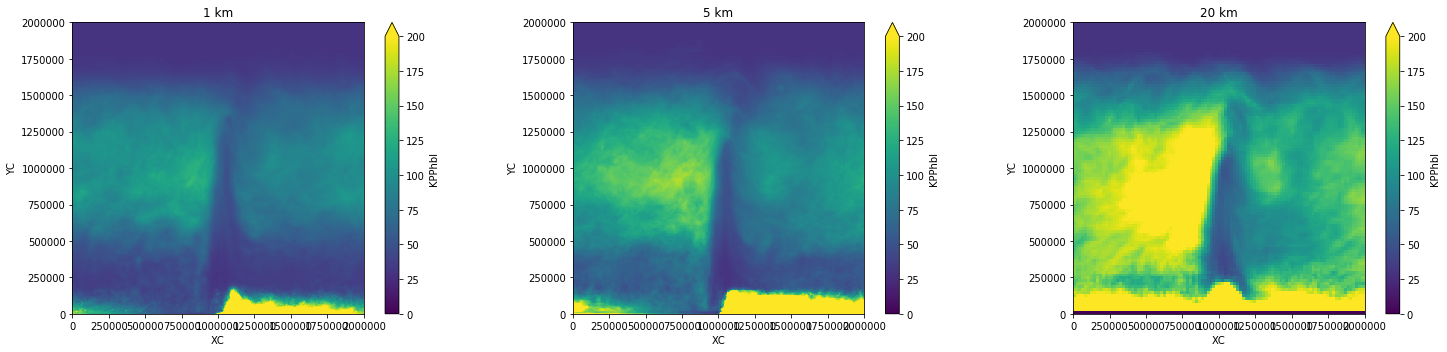

In [17]:
# calculate the mixing depth
fig = plt.figure(figsize = (21,5))

n=0
Hmix_perc ={}

for key in res:
    
    ax = fig.add_subplot(131 + n)
    KPP_coarse[key].KPPhbl.mean('time').plot(vmax=200)
    
    ax.set_aspect('equal')

    plt.title(label[key])
    n+=1
    
plt.tight_layout()

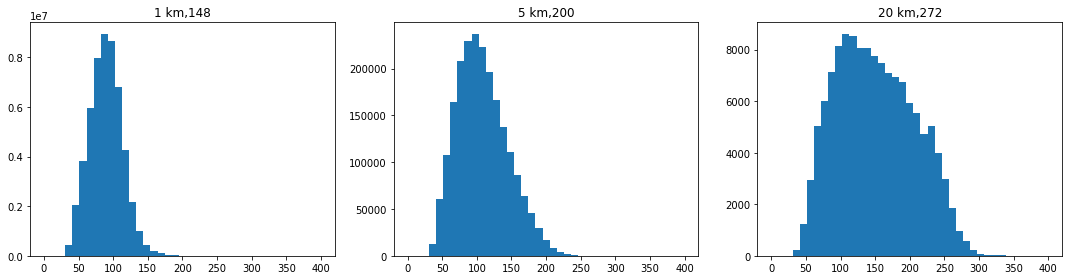

In [21]:
# calculate the mixing depth
plt.figure(figsize=(15,4))
n=0
Hmix_perc ={}
for key in res:
    hboundary = KPP_coarse[key].KPPhbl.sel(YC=slice(ylevs[0], ylevs[1]))
    a = hboundary.values
    
    
    ars = a.reshape(a.shape[0]*a.shape[1]*a.shape[2])
    
    
    plt.subplot(131+n)
    bins = np.linspace(0,400,40)
    plt.hist(ars, bins)
    Hmix_perc[key] = np.percentile(ars,99)
    plt.title(label[key] +',' + str(int(np.percentile(ars,99))))
    n+=1
    
plt.tight_layout()

In [22]:
Hmix_perc

{'01': 148.91334609985336, '05': 200.39475387573242, '20': 272.41587585449213}

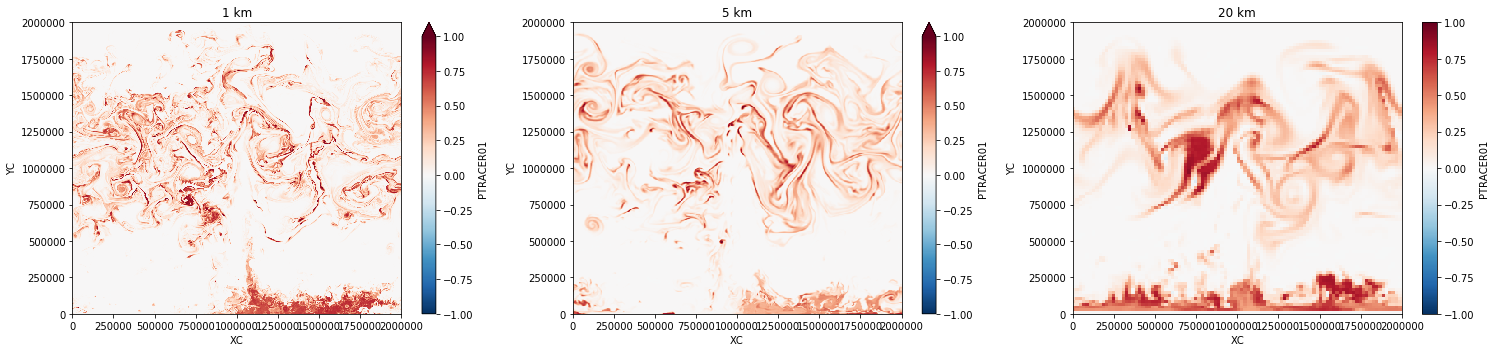

In [201]:
fig = plt.figure(figsize=(21,5))
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    res_time[key]['data_main'].PTRACER01.sel(Z=-Hmix_perc['20'], method='nearest'
                                            ).sel(time=864000*5., ).plot(vmin = -1)
    n+=1
    plt.title(label[key])
plt.tight_layout()

KeyError: 4320000

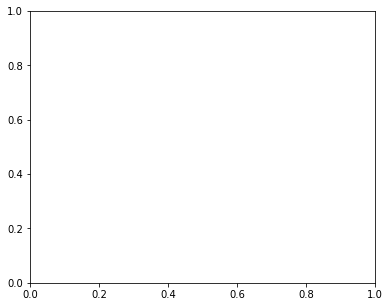

In [18]:
fig = plt.figure(figsize=(21,5))
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    res_time[key]['data_main'].PTRACER01.sel(Z=-Hmix_perc[key], method='nearest'
                                            ).sel(time=864000*5.).plot(vmin = -1)
    n+=1
    plt.title(label[key])
plt.tight_layout()

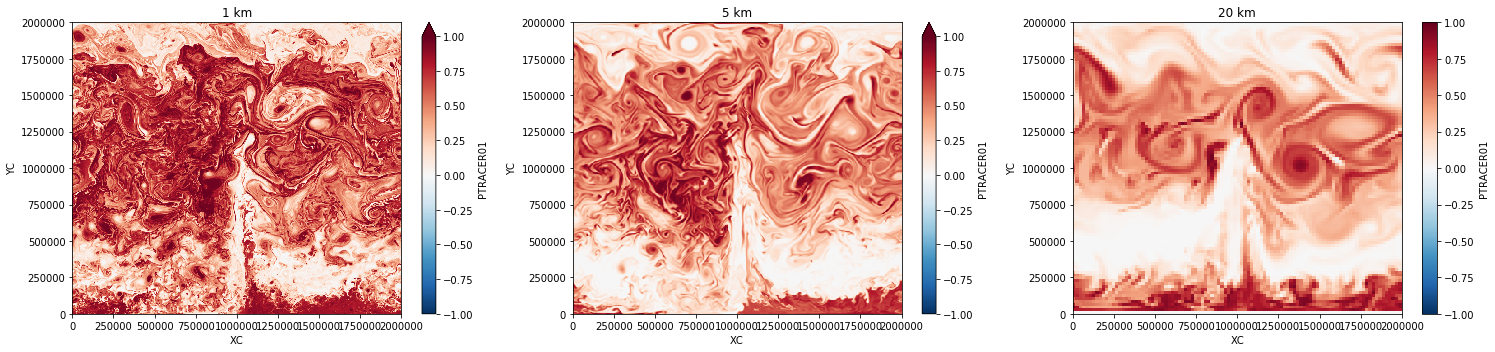

In [19]:
fig = plt.figure(figsize=(21,5))
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    res_time[key]['data_main'].PTRACER01.sel(Z=-Hmix_perc[key], method='nearest'
                                            ).isel(time=-1).plot(vmin = -1)
    n+=1
    plt.title(label[key])
plt.tight_layout()

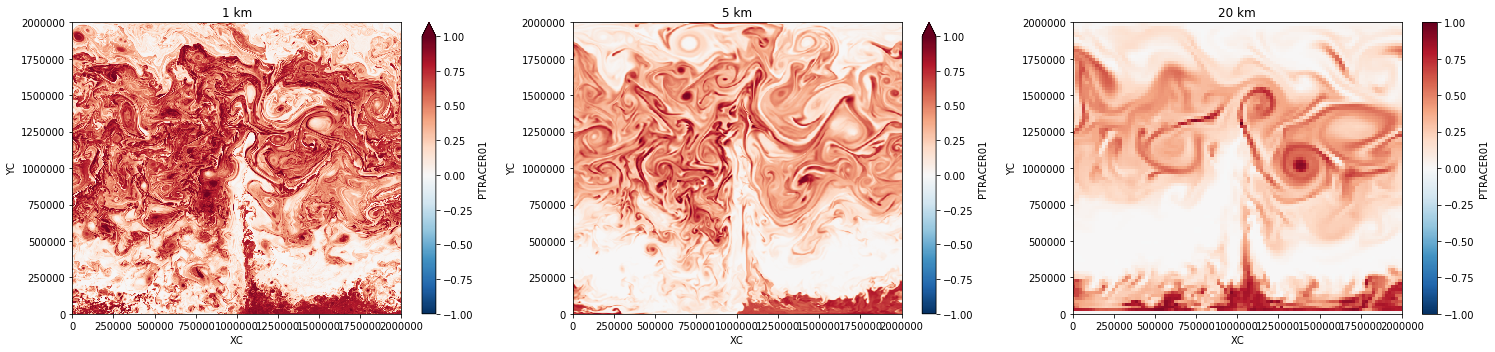

In [21]:
fig = plt.figure(figsize=(21,5))
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    res_time[key]['data_main'].PTRACER01.sel(Z=-Hmix_perc[key]-50, method='nearest'
                                            ).isel(time=-1).plot(vmin = -1)
    n+=1
    plt.title(label[key])
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


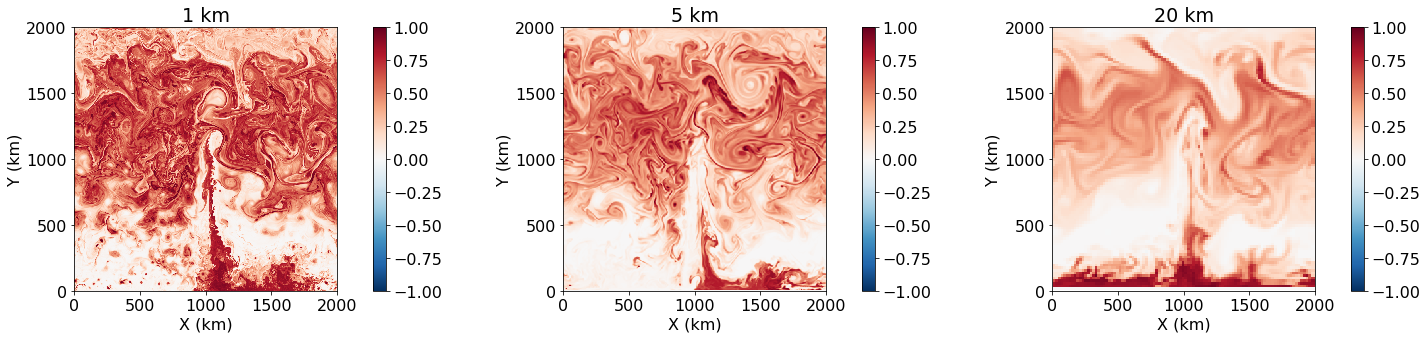

In [59]:
fig = plt.figure(figsize=(24,5))
plt.rcParams['font.size'] = 16
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    X = res_time[key]['data_main'].PTRACER01.XC
    Y = res_time[key]['data_main'].PTRACER01.YC 
    Z = res_time[key]['data_main'].PTRACER01.sel(Z=-Hmix_perc[key]-100, method='nearest').isel(time=-1)
    
    plt.pcolor( X/1e3,Y/1e3,Z , vmin=-1,vmax=1, cmap = 'RdBu_r')

    ax.set_aspect('equal')
    plt.title(label[key])
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')    
    n+=1
    plt.colorbar()
    plt.xticks([0, 500, 1000, 1500, 2000])
    plt.yticks([0, 500, 1000, 1500, 2000])

plt.tight_layout()
plt.savefig('tracer_maps_100m_below_MLD.png', format='png', dpi=300)


# Horizontal Spectra. 

In [11]:
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

In [14]:
# EKE spectrum for Upstream region
xlevs = [0,800e3]
ylevs = [600e3, 1400e3]
#xlevs2 = [600e3,1400e3]

Ups_us = {}
Vps_us = {}
EKEps_us = {}
Udata_us = {}
Vdata_us = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')
    
    U_us  = res_time[key]['data_main']['U']
    U_us  = grid.interp(U_us, 'X')
    U_us  = U_us.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1])).sel(Z = 0 , method='nearest')
    Udata_us[key] = U_us
    Udata_us[key].load()
    
    V_us  = res_time[key]['data_main']['V']
    V_us  = grid.interp(V_us, 'Y', boundary='extend')
    V_us  = V_us.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1])).sel(Z = 0 , method='nearest')
    Vdata_us[key] = V_us
    Vdata_us[key].load()

    
    Ups_us[key]  = xrft.power_spectrum(Udata_us[key], dim=['XC','YC'], window='hanning')
    Vps_us[key]  = xrft.power_spectrum(Vdata_us[key], dim=['XC','YC'], window='hanning')    
        
    EKEps_us[key] = 0.5*(Ups_us[key] + Vps_us[key])

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [15]:
# EKE spectrum for downstream region 
xlevs = [800e3,1600e3]
#xlevs2 = [600e3,1400e3]

Ups_ds = {}
Vps_ds = {}
EKEps_ds = {}
Udata_ds = {}
Vdata_ds = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')


    U_ds  = res_time[key]['data_main']['U']# - res_time[key]['data_mean'].Ttave.mean('time')
    U_ds  = grid.interp(U_ds, 'X')
    U_ds  = U_ds.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1])).sel(Z = 0 , method='nearest')
    Udata_ds[key] = U_ds
    Udata_ds[key].load()
    
    V_ds  = res_time[key]['data_main']['V']# - res_time[key]['data_mean'].Ttave.mean('time')
    V_ds  = grid.interp(V_ds, 'Y', boundary='extend')
    V_ds  = V_ds.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1])).sel(Z = 0 , method='nearest')
    Vdata_ds[key] = V_ds
    Vdata_ds[key].load()

    
    Ups_ds[key]  = xrft.power_spectrum(Udata_ds[key], dim=['XC','YC'], window='hanning')
    Vps_ds[key]  = xrft.power_spectrum(Vdata_ds[key], dim=['XC','YC'], window='hanning')    
        
    EKEps_ds[key] = 0.5*(Ups_ds[key] + Vps_ds[key])
        

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [11]:
# Cross spectra of vertical velocity for Downstream region 
xlevs = [800e3,1600e3]
#xlevs2 = [600e3,1400e3]


Wps_ds = {}
Wdata_ds = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')

    W_ds  = res_time[key]['data_main']['W']

    W_ds  = W_ds.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))
    Wdata_ds[key] = W_ds
    Wdata_ds[key].load()
    
    
    Wps_ds[key]  = xrft.power_spectrum(Wdata_ds[key], dim=['XC','YC'], window='hanning')
    #Vps_ds[key]  = xrft.power_spectrum(Vdata_ds[key], dim=['XC','YC'], window='hanning')    
        
    #EKEps_ds[key] = 0.5*(Ups_ds[key] + Vps_ds[key])
        

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [12]:
# Cross spectra of vertical velocity for Upstream region 
xlevs = [0,800e3]
#xlevs2 = [600e3,1400e3]


Wps_us = {}
Wdata_us = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')

    W_us  = res_time[key]['data_main']['W']

    W_us  = W_us.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))
    
    Wdata_us[key] = W_us
    Wdata_us[key].load()
    
    
    Wps_us[key]  = xrft.power_spectrum(Wdata_us[key], dim=['XC','YC'], window='hanning')
    #Vps_ds[key]  = xrft.power_spectrum(Vdata_ds[key], dim=['XC','YC'], window='hanning')    
        
    #EKEps_ds[key] = 0.5*(Ups_ds[key] + Vps_ds[key])
        

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [16]:
EKEps_us_mean = {}
EKEps_ds_mean = {}
Vps_us_mean = {}
Vps_ds_mean = {}

for key in res:
    EKEps_us_mean[key] = EKEps_us[key].mean('time')
    EKEps_ds_mean[key] = EKEps_ds[key].mean('time')
    Vps_us_mean[key]   = Vps_us[key].mean('time')
    Vps_ds_mean[key]   = Vps_ds[key].mean('time')

In [14]:
Wps_us_mean = {}
Wps_ds_mean = {}

for key in res:
   
    Wps_us_mean[key]   = Wps_us[key].mean('time')
    Wps_ds_mean[key]   = Wps_ds[key].mean('time')

In [17]:
def iso_spec(ds):
    
#    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    nfactor = 4. 
    ds_iso = np.zeros([int(klen/nfactor+1)])


    kr, ds_iso = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds, 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'kr':kr }, dims=['kr'])
    
    return ds_iso_xr
        
def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Zl)
    klen = len(ds.freq_XC)
    nfactor = 4. 
    ds_iso = np.zeros([Zlen, int(klen/nfactor+1)])

    for i in range(0,Zlen):
        kr, ds_iso[i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Zl=i), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'Z': ds.Zl.values, 'kr':kr }, dims=['Z', 'kr'])
    
    return ds_iso_xr
        
    

In [18]:
EKEps1D_us  = {}
EKEps1D_ds  = {}

Vps1D_us  = {}
Vps1D_ds  = {}

for key in res:
    EKEps1D_us[key] = iso_spec(EKEps_us_mean[key])
    EKEps1D_ds[key] = iso_spec(EKEps_ds_mean[key])
    Vps1D_us[key] = iso_spec(Vps_us_mean[key])
    Vps1D_ds[key] = iso_spec(Vps_ds_mean[key])

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [18]:
Wps_us_mean['01']

<xarray.DataArray (Zl: 76, freq_YC: 800, freq_XC: 800)>
array([[[  5.558890e-12,   4.081080e-12, ...,   4.779063e-12,   4.081080e-12],
        [  4.633151e-12,   4.413001e-12, ...,   4.355318e-12,   3.520261e-12],
        ..., 
        [  3.706504e-12,   4.019034e-12, ...,   5.634043e-12,   4.862186e-12],
        [  4.633151e-12,   3.520261e-12, ...,   5.612309e-12,   4.413001e-12]],

       [[  7.584331e-08,   6.889327e-08, ...,   8.158158e-08,   6.889327e-08],
        [  8.119188e-08,   6.776404e-08, ...,   6.732524e-08,   7.740385e-08],
        ..., 
        [  8.721621e-08,   7.075020e-08, ...,   5.046230e-08,   7.235674e-08],
        [  8.119188e-08,   7.740385e-08, ...,   5.385673e-08,   6.776404e-08]],

       ..., 
       [[  2.312265e-05,   2.224886e-05, ...,   2.172982e-05,   2.224886e-05],
        [  2.125760e-05,   2.005211e-05, ...,   1.878164e-05,   1.564410e-05],
        ..., 
        [  1.735989e-05,   1.184702e-05, ...,   2.318305e-05,   1.749188e-05],
        [  2.125

In [28]:

Wps1D_us  = {}
Wps1D_ds  = {}

for key in res:
  
    Wps1D_us[key] = iso_spec_over_depth(Wps_us_mean[key])
    Wps1D_ds[key] = iso_spec_over_depth(Wps_ds_mean[key])

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [21]:
Wps1D_us

{'01': <xarray.DataArray (kr: 201)>
 array([           nan,   1.693854e-06,   9.456941e-06, ...,   4.424319e-07,
          4.377352e-07,   2.646580e-07])
 Coordinates:
   * kr       (kr) float64 0.0 1.698e-06 3.866e-06 6.306e-06 8.755e-06 ...,
 '05': <xarray.DataArray (kr: 41)>
 array([           nan,   6.528984e-07,   2.658171e-06,   4.558496e-06,
          4.902331e-06,   4.220172e-06,   4.008210e-06,   3.634893e-06,
          3.318234e-06,   3.333006e-06,   3.249934e-06,   3.249191e-06,
          3.273542e-06,   3.331372e-06,   3.636250e-06,   3.602225e-06,
          4.021975e-06,   4.226061e-06,   4.470313e-06,   4.683559e-06,
          4.887326e-06,   4.981440e-06,   5.258910e-06,   5.396232e-06,
          5.308062e-06,   5.256858e-06,   5.041240e-06,   4.905936e-06,
          4.513526e-06,   4.229410e-06,   3.929795e-06,   3.551277e-06,
          3.255614e-06,   2.946063e-06,   2.652749e-06,   2.420875e-06,
          2.200513e-06,   2.057092e-06,   1.849779e-06,   1.755643e-06,
 

In [30]:
colors[1]

TypeError: 'module' object is not subscriptable

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


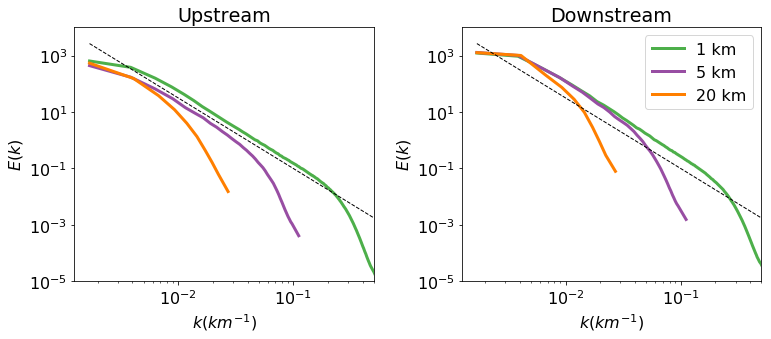

In [65]:
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(11,5))
n=2
for key in res:
    k = EKEps1D_us[key].kr*1e3
    
    plt.subplot(121)
    plt.plot(k, EKEps1D_us[key], linewidth=3, label=label[key], color= colors[n])
    
    plt.subplot(122)
    plt.plot(k, EKEps1D_ds[key], linewidth=3, label=label[key], color= colors[n])
    
    n+=1
    
plt.subplot(121)
k = EKEps1D_us['01'].kr*1e3
#plt.plot(k, 1e-13*k**-3, color='k')
#plt.plot(k, 1e-8*k**-2, color='k')
plt.plot(k, 10**(-3.5)*k**-2.5,'--', linewidth=1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-5 ,10**4])
plt.xlim([1/800, 1/2])
plt.title('Upstream')
plt.xlabel('$k (km^{-1})$')
plt.ylabel('$E(k)$')

plt.subplot(122)
plt.legend()
k = EKEps1D_us['01'].kr*1e3
#plt.plot(k, 1e-12*k**-3, color='k')
#plt.plot(k, 1e-8*k**-2, color='k')
plt.plot(k, 10**(-3.5)*k**-2.5,'--', linewidth=1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-5 ,10**4])
plt.xlim([1/800, 1/2])
plt.title('Downstream')
plt.xlabel('$k (km^{-1})$')
plt.ylabel('$E(k)$')
plt.tight_layout()

#plt.savefig('figures/EK_both.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


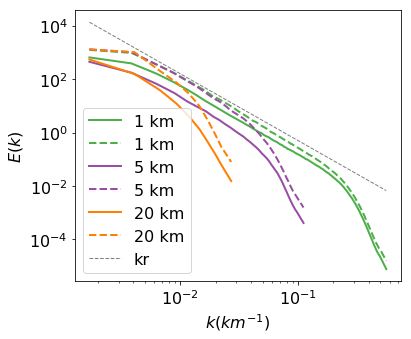

In [74]:
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(6,5))
n=2
for key in res:
    
    k = EKEps1D_us[key].kr*1e3
    
    plt.subplot(111)
    plt.plot(k, EKEps1D_us[key], linewidth=2, label=label[key], color= colors[n])
    
    plt.plot(k, EKEps1D_ds[key], '--',linewidth=2, label=label[key], color= colors[n])
    
    n+=1
    
k = EKEps1D_us['01'].kr*1e3
#plt.plot(k, 1e-13*k**-3, color='k')
#plt.plot(k, 1e-8*k**-2, color='k')
plt.plot(k, 10**(-2.8)*k**-2.5,'--', linewidth=1, color='gray')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([10**-5 ,10**4])
#plt.xlim([1/800, 1/2])

plt.xlabel('$k (km^{-1})$')
plt.ylabel('$E(k)$')

plt.tight_layout()
plt.legend()

plt.savefig('figures/EK_together.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


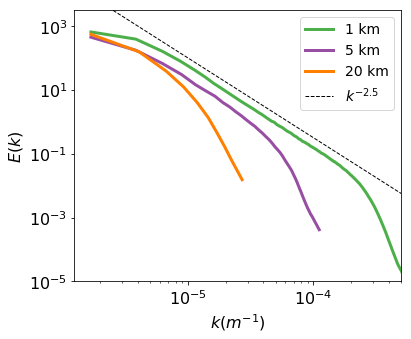

In [62]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

fig = plt.figure(figsize=(6,5))
n=2
for key in res:
    k = EKEps1D_us[key].kr
    
    plt.subplot(111)
    EKEps1D_us[key].plot(linewidth=3, label=label[key], color= colors[n])
    n+=1

plt.subplot(111)
k = EKEps1D_us['01'].kr

# slopes
#plt.plot(k, 1e-13*k**-3, color='k')
#plt.plot(k, 1e-8*k**-2, color='k')
plt.plot(k, 10**(-10.5)*k**-2.5,'--', linewidth=1, color='k', label='$k^{-2.5}$')

# Deformation radius 
rd = 25e3
ld = 2*np.pi*rd
kd = 1/ld
yax = np.linspace(10**-5 ,10**4,20)
#plt.plot(kd*yax/yax, yax, '-.', label= '$k_{D}$')

# MlI peak 
lmli = 2*np.pi/3e-3
kmli = 1/lmli
#plt.plot(kmli*yax/yax, yax, '-.', label= '$k_{mli}$')

plt.legend(fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-5 ,10**3.5])
plt.xlim([1/800e3, 1/2e3])
#plt.title('Upstream')
plt.xlabel('$k (m^{-1})$')
plt.ylabel('$E(k)$')
plt.tight_layout()
plt.savefig('figures/EK_upstream.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


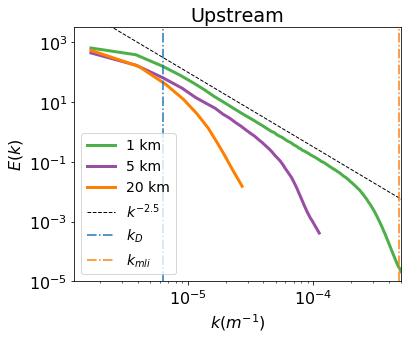

In [78]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

fig = plt.figure(figsize=(6,5))
n=2
for key in res:
    k = EKEps1D_us[key].kr
    
    plt.subplot(111)
    EKEps1D_us[key].plot(linewidth=3, label=label[key], color= colors[n])
    n+=1

plt.subplot(111)
k = EKEps1D_us['01'].kr

# slopes
#plt.plot(k, 1e-13*k**-3, color='k')
#plt.plot(k, 1e-8*k**-2, color='k')
plt.plot(k, 10**(-10.5)*k**-2.5,'--', linewidth=1, color='k', label='$k^{-2.5}$')

# Deformation radius 
rd = 25e3
ld = 2*np.pi*rd
kd = 1/ld
yax = np.linspace(10**-5 ,10**4,20)
plt.plot(kd*yax/yax, yax, '-.', label= '$k_{D}$')

# MlI peak 
lmli = 2*np.pi/3e-3
kmli = 1/lmli
plt.plot(kmli*yax/yax, yax, '-.', label= '$k_{mli}$')

plt.legend(fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-5 ,10**3.5])
plt.xlim([1/800e3, 1/2e3])
plt.title('Upstream')
plt.xlabel('$k (m^{-1})$')
plt.ylabel('$E(k)$')
plt.tight_layout()
#plt.savefig('figures/EK_upstream.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1e-07, 0.0001)

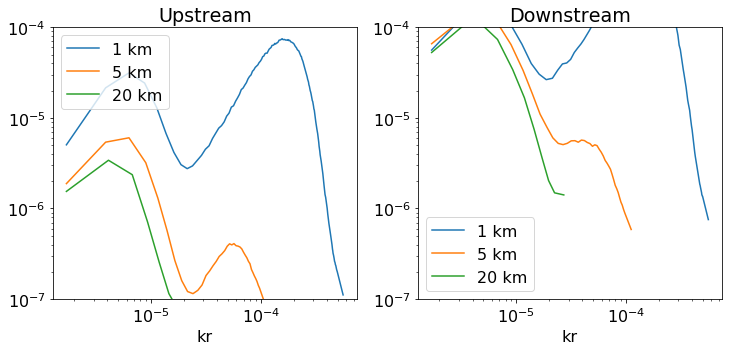

In [24]:
fig = plt.figure(figsize=(12,5))
for key in res:
    plt.subplot(121)
    Wps1D_us[key].plot(label=label[key])
    
    plt.subplot(122)
    Wps1D_ds[key].plot(label=label[key])

plt.subplot(121)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Upstream')
plt.ylim(1e-7, 1e-4)

plt.subplot(122)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Downstream')
plt.ylim(1e-7, 1e-4)

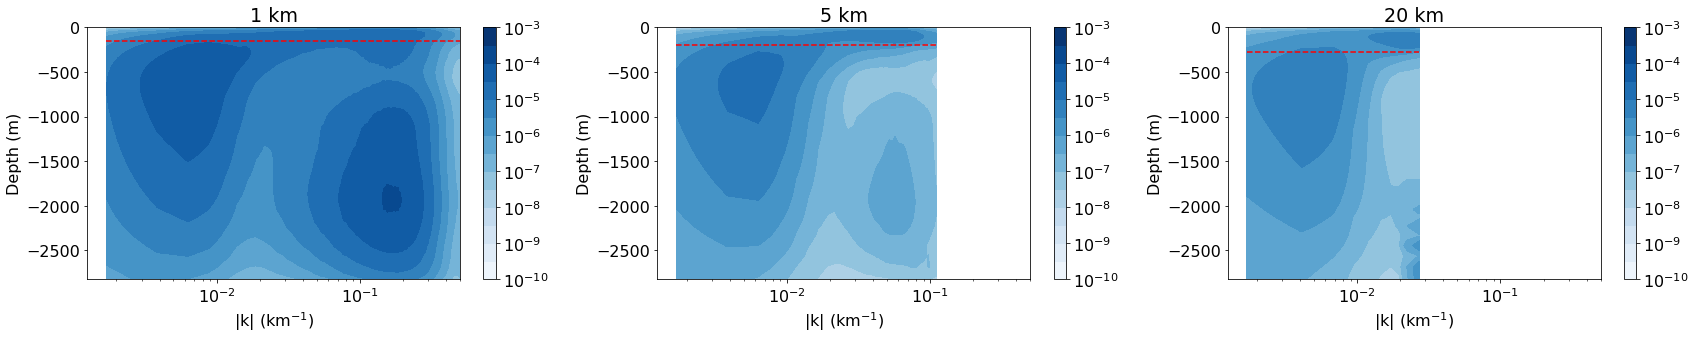

In [46]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.linspace(-10, -3,15)
levs = np.power(10., lev_exp)

for key in res:
    kr = Wps1D_us[key].kr*1e3
    Z = Wps1D_us[key].Z    
    dat = Wps1D_us[key]
    
    plt.subplot(131+n)
    plt.contourf(kr, Z, dat, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

plt.savefig('w_spec_upstream.png', format='png', dpi=300)


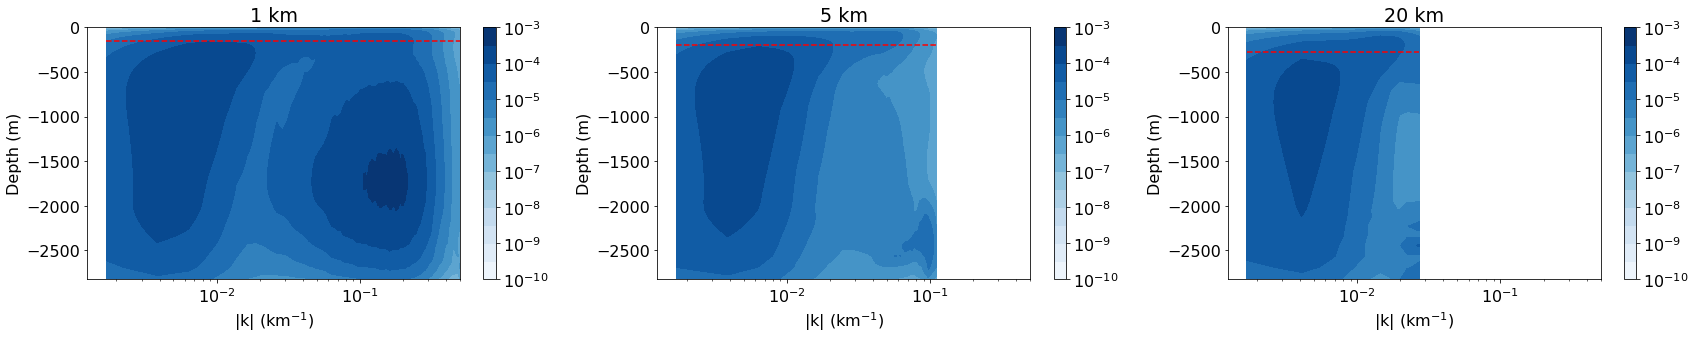

In [47]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.linspace(-10, -3,15)
levs = np.power(10., lev_exp)

for key in res:
    kr = Wps1D_ds[key].kr*1e3
    Z = Wps1D_ds[key].Z    
    dat = Wps1D_ds[key]
    
    plt.subplot(131+n)
    plt.contourf(kr, Z, dat, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

plt.savefig('w_spec_downstream.png', format='png', dpi=300)


In [ ]:
plt.figure(figsize=(24,5))

n=0 
lev_exp = np.linspace(-10, -3,15)
levs = np.power(10., lev_exp)

for key in res:
    kr = Wps1D_ds[key].kr*1e3
    Z = Wps1D_ds[key].Z    
    dat = Wps1D_ds[key]
    
    plt.subplot(311+n)
    plt.contourf(kr, Z, dat, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

plt.savefig('w_spec_downstream.png', format='png', dpi=300)


In [71]:
W4plot ={ }
for key in res_time.keys():
    ax = fig.add_subplot(131+n)
    X = res_time[key]['data_main'].XC/1e3
    Y = res_time[key]['data_main'].YC/1e3
    W4plot[key] = res_time[key]['data_main'].W.sel(Zl=-100,method='nearest').isel(time=-1).load()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


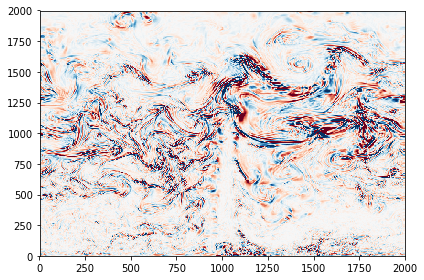

In [77]:
[XG, YG] = np.meshgrid(X,Y)
plt.pcolormesh(XG,YG, W4plot['05'],vmin=-0.0004, vmax= 0.0004, cmap='RdBu_r')



In [73]:
XG.shape

(400, 400)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


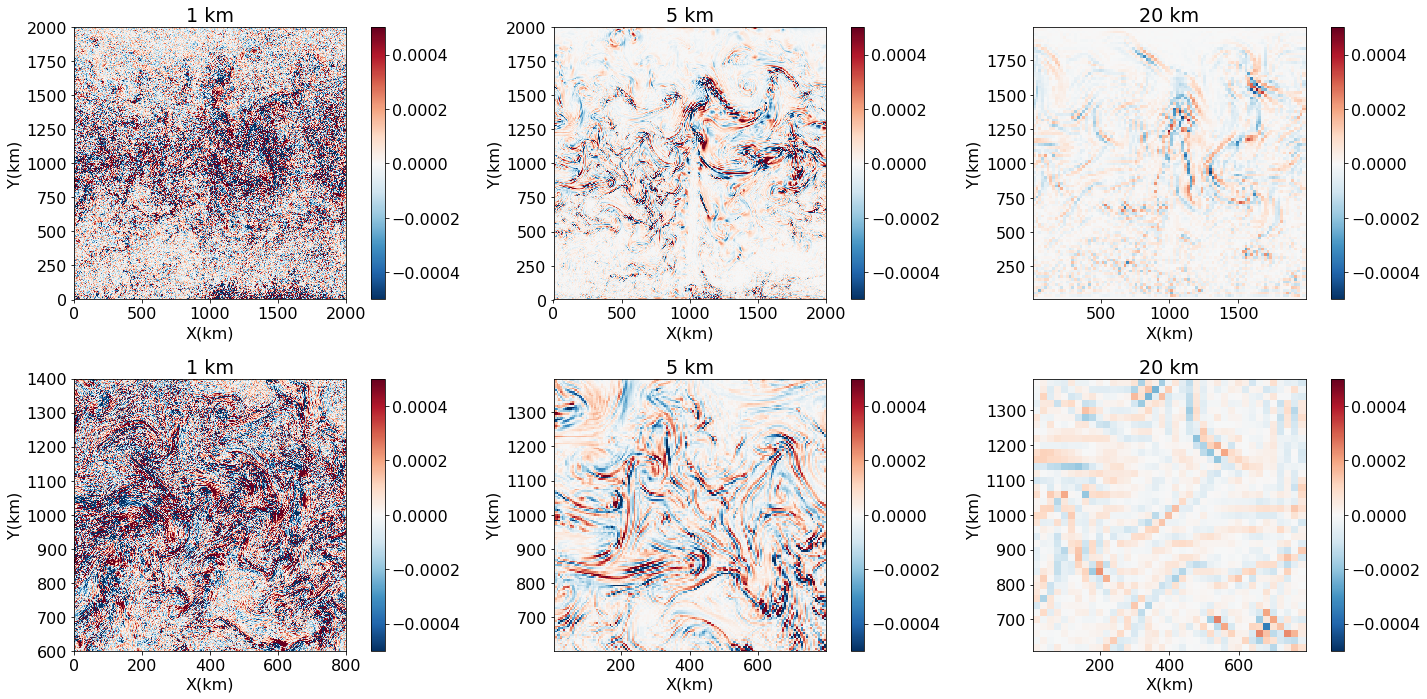

In [88]:
fig = plt.figure(figsize=(21,10))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=0
for key in ['01','05','20']:
    ax = fig.add_subplot(231+n)
    X = res_time[key]['data_main'].XC/1e3
    Y = res_time[key]['data_main'].YC/1e3
    W = res_time[key]['data_main'].W.sel(Zl=-100,method='nearest').isel(time=-1)
    [XG, YG] = np.meshgrid(X,Y)
    plt.pcolormesh(XG,YG, W, vmin=-0.0005, vmax=0.0005, cmap='RdBu_r')
    
    ax.set_aspect('equal')
    plt.title(label[key])
    plt.xlabel('X(km)')
    plt.ylabel('Y(km)')
    plt.colorbar()
    
    n+=1
    

for key in ['01','05','20']:
    ax = fig.add_subplot(231+n)
    X = res_time[key]['data_main'].XC.sel(XC=slice(0,800e3))/1e3
    Y = res_time[key]['data_main'].YC.sel( YC=slice(600e3,1400e3))/1e3
    W = res_time[key]['data_main'].W.sel(Zl=-100,method='nearest').sel(XC=slice(0,800e3), 
                                                                       YC=slice(600e3,1400e3)
                                                                      ).isel(time=-1)
    [XG, YG] = np.meshgrid(X,Y)
    plt.pcolormesh(XG,YG, W, vmin=-0.0005, vmax=0.0005, cmap='RdBu_r')
    
    ax.set_aspect('equal')
    plt.title(label[key])
    plt.xlabel('X(km)')
    plt.ylabel('Y(km)')
    plt.colorbar()
    
    n+=1
    
    plt.savefig('figures/W_synoptic.png', format='png', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


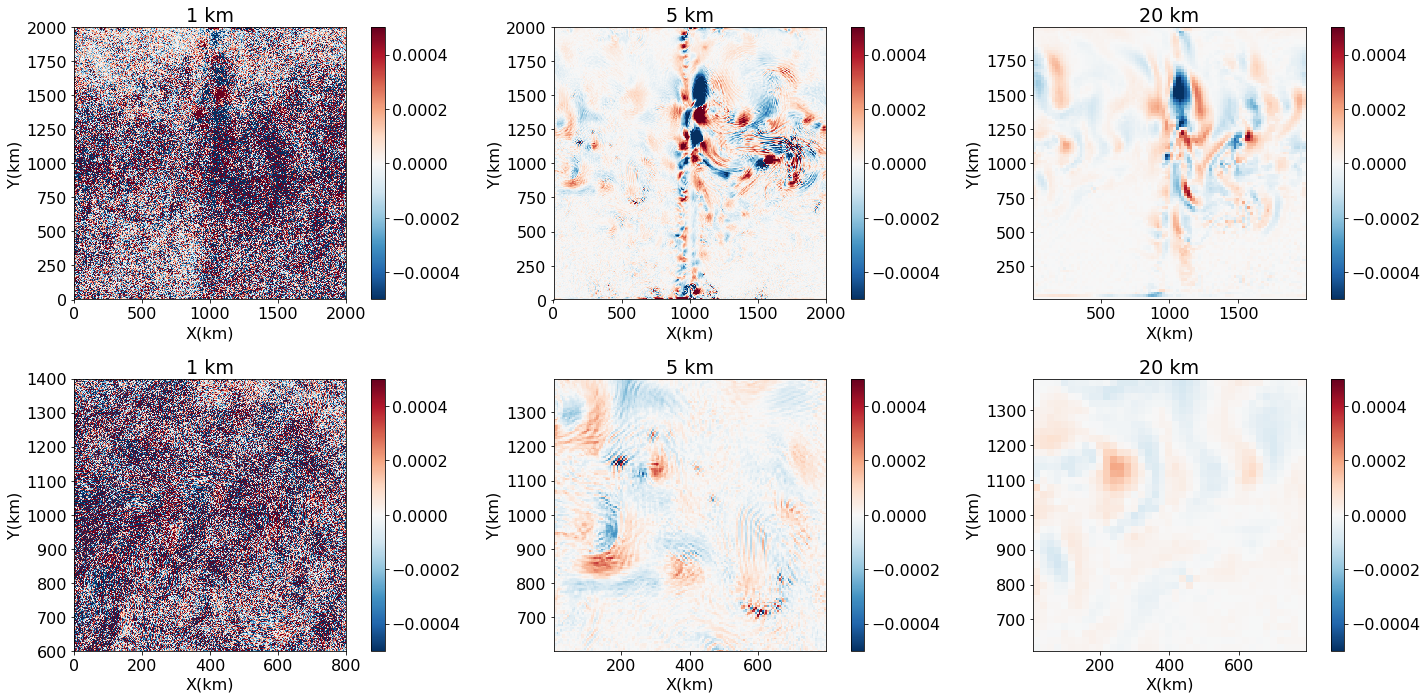

In [89]:
fig = plt.figure(figsize=(21,10))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=0
for key in ['01','05','20']:
    ax = fig.add_subplot(231+n)
    X = res_time[key]['data_main'].XC/1e3
    Y = res_time[key]['data_main'].YC/1e3
    W = res_time[key]['data_main'].W.sel(Zl=-1500,method='nearest').isel(time=-1)
    [XG, YG] = np.meshgrid(X,Y)
    plt.pcolormesh(XG,YG, W, vmin=-0.001, vmax=0.00, cmap='RdBu_r')
    
    ax.set_aspect('equal')
    plt.title(label[key])
    plt.xlabel('X(km)')
    plt.ylabel('Y(km)')
    plt.colorbar()
    
    n+=1
    

for key in ['01','05','20']:
    ax = fig.add_subplot(231+n)
    X = res_time[key]['data_main'].XC.sel(XC=slice(0,800e3))/1e3
    Y = res_time[key]['data_main'].YC.sel( YC=slice(600e3,1400e3))/1e3
    W = res_time[key]['data_main'].W.sel(Zl=-1500,method='nearest').sel(XC=slice(0,800e3), 
                                                                       YC=slice(600e3,1400e3)
                                                                      ).isel(time=-1)
    [XG, YG] = np.meshgrid(X,Y)
    plt.pcolormesh(XG,YG, W, vmin=-0.0005, vmax=0.0005, cmap='RdBu_r')
    
    ax.set_aspect('equal')
    plt.title(label[key])
    plt.xlabel('X(km)')
    plt.ylabel('Y(km)')
    plt.colorbar()
    
    n+=1
    
    plt.savefig('figures/W_synoptic_deep.png', format='png', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


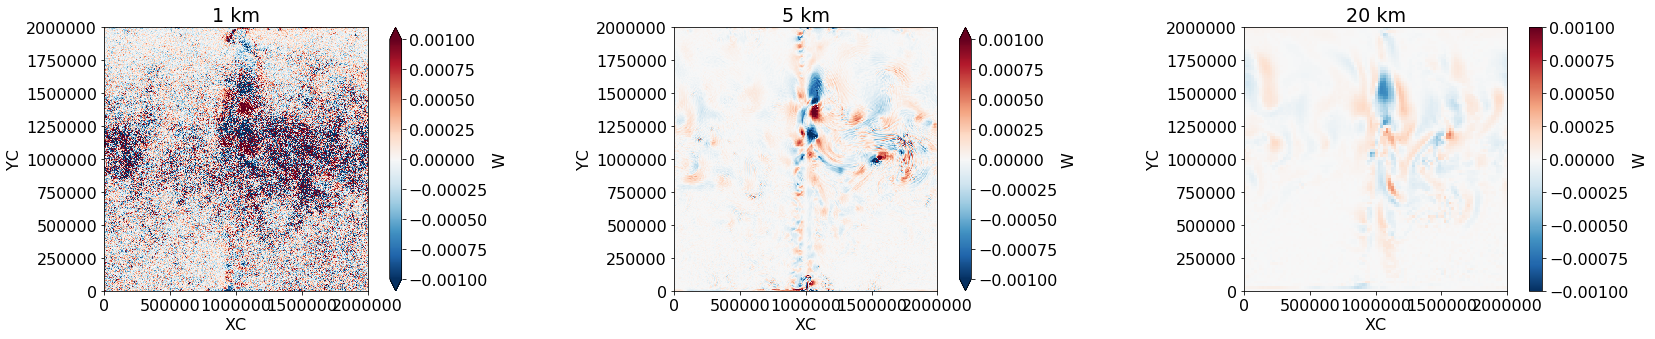

In [188]:
fig = plt.figure(figsize=(24,5))
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    res_time[key]['data_main'].W.sel(Zl=-1500, method='nearest').isel(time=-1).plot(vmin=-0.001)
    ax.set_aspect('equal')
    plt.title(label[key])
    n+=1

In [91]:
f0=-0.83E-04
beta=1.87E-11


In [93]:
res = sorted(res_time)

In [94]:
# Velocity PDFs, vorticity PDFs. 
vorticity = {}
for key in res: 
    ds = res_time[key]['data_main']
    grid = Grid(ds, periodic='X')
    
    f = f0 + beta*ds.YC
    
    dx = ds.dxG[0,0]
    dy = ds.dxG[0,0]
    # dv/dx - du/dy
    vorticity[key] = ( grid.interp(grid.diff(grid.interp(ds.V, 'Y', boundary='extend'), 'X'), 'X')/dx - 
                      grid.interp(grid.diff(grid.interp(ds.U, 'X'), 'Y', boundary='extend'), 'Y',boundary='extend') 
                      /dy)/f 

KeyboardInterrupt: 

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


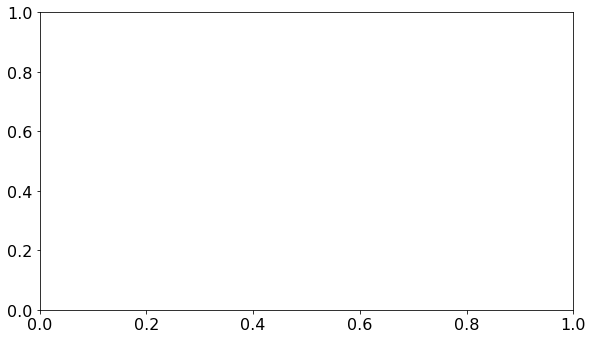

In [95]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(24,5))
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    X = vorticity[key].XC
    Y = vorticity[key].YC 
    Z = vorticity[key].sel(Z=0, method='nearest').isel(time=-1)
    
    plt.pcolor( X/1e3,Y/1e3,Z , vmin=-1,vmax=1, cmap = 'RdBu_r')

    ax.set_aspect('equal')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    
    plt.title(label[key])
    n+=1
    plt.colorbar()
    plt.xticks([0, 500, 1000, 1500, 2000])
    plt.yticks([0, 500, 1000, 1500, 2000])
    
plt.tight_layout()
#plt.savefig('vorticity_surface.png', format='png', dpi=300)
 

Text(0.5,1,'20 km')

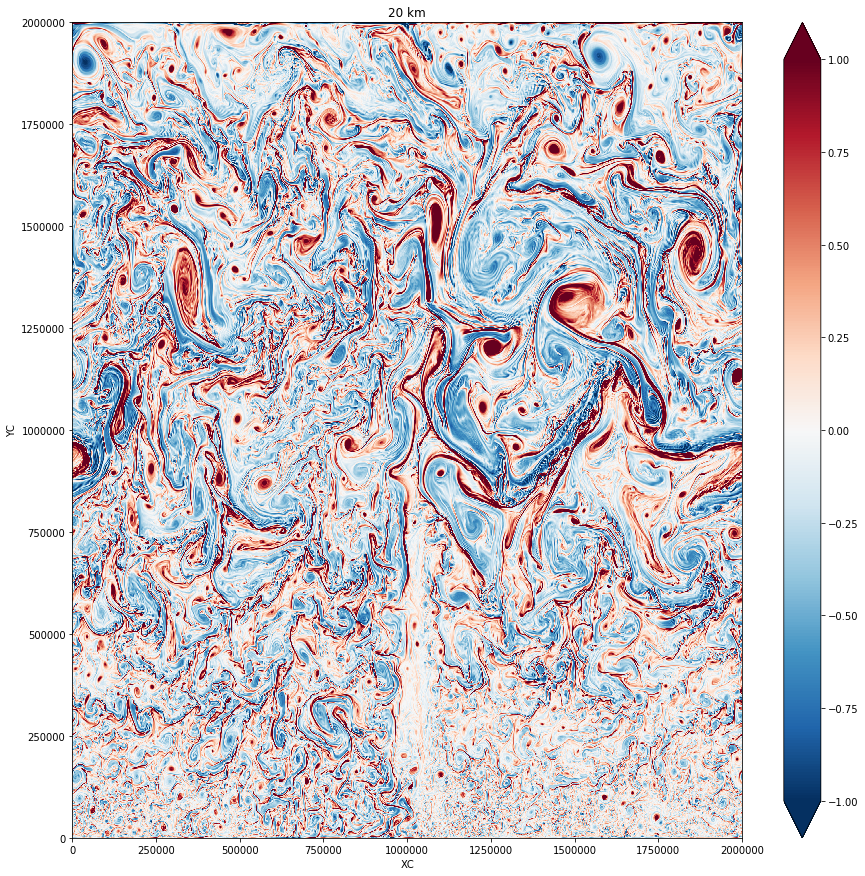

In [16]:
fig = plt.figure(figsize=(15,15))
n=0

vorticity['01'].sel(Z=0, method='nearest').isel(time=-1).plot(vmin=-1)
ax.set_aspect('equal')
plt.title(label[key])


In [96]:
from scipy.stats import gaussian_kde

In [97]:
x_us = slice(0, 800e3)
y_us = slice(600e3, 1400e3) 

vort_kernel_us = {}
for key in res:
    vort_rs = np.reshape(vorticity[key].isel(Z=0, time=-1).sel(XC=x_us, YC=y_us).data, -1 )
    vort_kernel_us[key] = gaussian_kde(vort_rs)
#    plt.plot(positions, vort_kernel(positions),'.-')
#    plt.yscale('log')

Text(0,0.5,'PDF')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


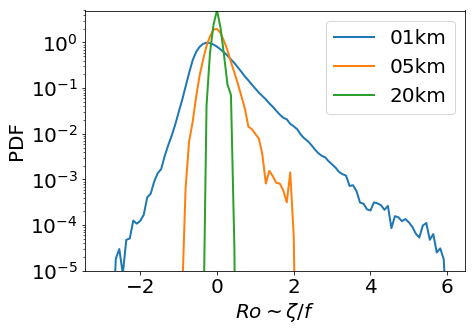

In [98]:
positions = np.linspace(-3,6,100)
plt.rcParams['font.size'] = 20
plt.figure(figsize=(7,5))

for key in res:
    plt.plot(positions, vort_kernel_us[key](positions),linewidth=2, label=key+'km')
plt.yscale('log')
plt.ylim([1e-5,5])
plt.legend()
plt.xlabel('$Ro \sim \zeta/f$')
plt.ylabel('PDF')
#plt.grid('on')

In [99]:
x_ds = slice(1000, 1800e3)
y_ds = slice(600e3, 1400e3) 

vort_kernel_ds = {}
for key in res:
    vort_rs = np.reshape(vorticity[key].isel(Z=0, time=-1).sel(XC=x_ds, YC=y_ds).data, -1 )
    vort_kernel_ds[key] = gaussian_kde(vort_rs)
#    plt.plot(positions, vort_kernel(positions),'.-')
#    plt.yscale('log')

In [100]:
start = 0.0
stop = 1.0
number_of_lines=9
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ plt.cm.Set1(x) for x in cm_subsection ]

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


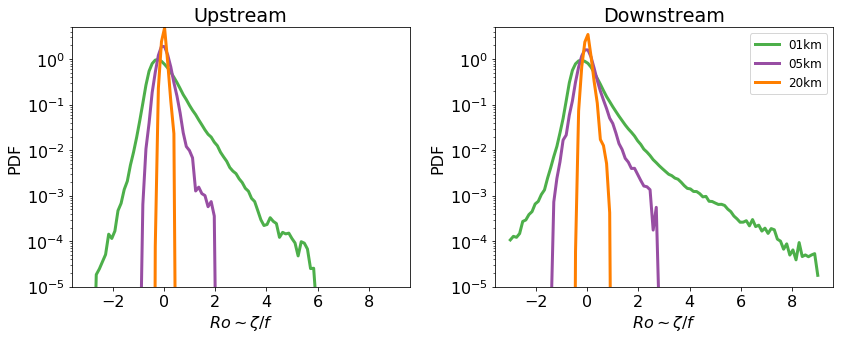

In [103]:
positions = np.linspace(-3,9,100)
plt.rcParams['font.size'] = 16
plt.figure(figsize=(12,5))

n=2
for key in res:
    plt.subplot(121)
    plt.plot(positions, vort_kernel_us[key](positions),linewidth=3, label=key+'km',color = colors[n])
    plt.subplot(122)
    plt.plot(positions, vort_kernel_ds[key](positions),linewidth=3, label=key+'km',color = colors[n])
    n+=1
    
plt.subplot(121)
plt.yscale('log')
plt.ylim([1e-5,5])
#plt.legend(fontsize=12)
plt.xlabel('$Ro \sim \zeta/f$')
plt.ylabel('PDF')
plt.title('Upstream')

plt.subplot(122)
plt.yscale('log')
plt.ylim([1e-5,5])
plt.legend(fontsize=12)
plt.xlabel('$Ro \sim \zeta/f$')
plt.ylabel('PDF')
plt.title('Downstream')
#plt.grid('on')
plt.tight_layout()
plt.savefig('figures/vorticity_pdf.eps', format='eps', dpi=100)

In [156]:
# Vertical velocity PDFs
diff_profiles = {}

for key in res:
    diff_profiles[key] = KPP_coarse[key].KPPdiffT.isel(time=-1).sel(YC=slice(600e3, 1400e3)).mean(['XC','YC'])
    

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


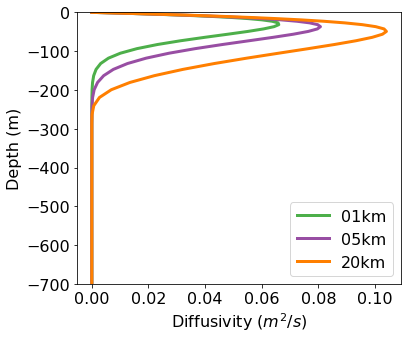

In [163]:
positions = np.linspace(-3,9,100)
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,5))

n=2
for key in res:
    plt.plot(diff_profiles[key], diff_profiles[key].Zl, color= colors[n], linewidth=3, label=key+'km')
    x = np.linspace(-100,100,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1
    
plt.ylim([-700,0])
plt.xlim([0.005])
plt.ylabel('Depth (m)')
plt.xlabel('Diffusivity ($m^2/s$)')
plt.legend()
plt.tight_layout
plt.savefig('figures/diffusivity_profiles.eps', format='eps', dpi=1000)

In [75]:
# Vertical velocity PDFs
wvar_profiles_us = {}
wvar_profiles_ds = {}
for key in res:
    wvar_profiles_us[key] = res_time[key]['data_main'].W.isel(time=slice(20,34)).sel(YC=slice(600e3, 1400e3),XC=slice(0,800e3)
                                                                      ).std(['XC','YC','time'])
    wvar_profiles_ds[key] = res_time[key]['data_main'].W.isel(time=slice(20,34)).sel(YC=slice(600e3, 1400e3),XC=slice(1000e3, 1800e3)
                                                                      ).std(['XC','YC','time'])
    
#res_time['20']['data_main'].W.isel(time=-1).sel(YC=slice(600e3, 1400e3)).var(['XC','YC']).plot()

In [76]:
Hmix_perc

{'01': 148.91334609985336, '05': 200.39475387573242, '20': 272.4158758544921}

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


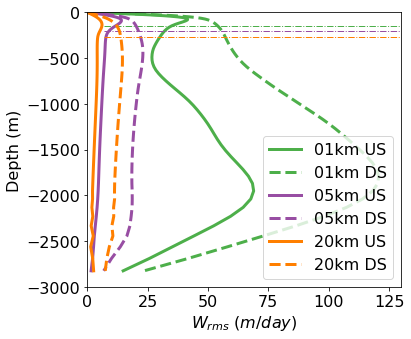

In [77]:
positions = np.linspace(-3,9,100)
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,5))

n=2
for key in res:
    plt.plot(wvar_profiles_us[key]*86400, wvar_profiles_us[key].Zl, color= colors[n], linewidth=3, label=key+'km US')
    plt.plot(wvar_profiles_ds[key]*86400, wvar_profiles_ds[key].Zl, '--', color= colors[n], linewidth=3, label=key+'km DS')
    x = np.linspace(0,130,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1

plt.ylim([-3000,0])
plt.xlim([0,130])

plt.ylabel('Depth (m)')
plt.xlabel('$W_{rms}$ ($m/day$)')
plt.legend()
plt.tight_layout
plt.savefig('figures/wrms_profiles_deep.eps', format='eps', dpi=300)    

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


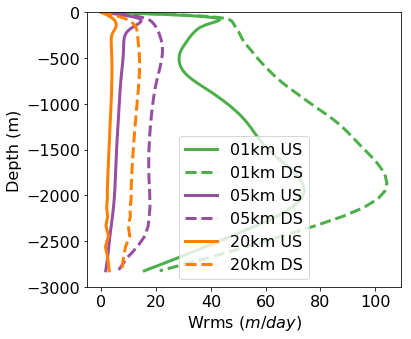

In [184]:
positions = np.linspace(-3,9,100)
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,5))

n=2
for key in res:
    plt.plot(wvar_profiles_us[key]*86400, wvar_profiles_us[key].Zl, color= colors[n], linewidth=3, label=key+'km US')
    plt.plot(wvar_profiles_ds[key]*86400, wvar_profiles_ds[key].Zl, '--', color= colors[n], linewidth=3, label=key+'km DS')
    n+=1
    
plt.ylim([-3000,0])

plt.ylabel('Depth (m)')
plt.xlabel('Wrms ($m/day$)')
plt.legend()
plt.tight_layout
plt.savefig('figures/wrms_profiles_deep.eps', format='eps', dpi=1000)    

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


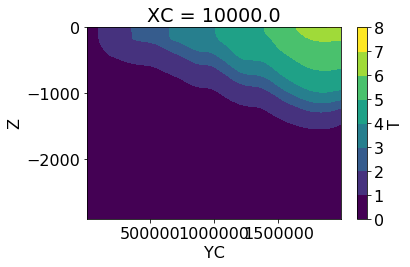

In [110]:
# plots of temperature meridional sections 
res_time['20']['data_main']['T'].isel(XC=0).mean('time').plot.contourf(levels=np.linspace(0,8,9))

In [ ]:
res_time['20']['data_main']['T'].isel(XC=0).mean('time').plot.contourf(levels=np.linspace(0,8,9))